In [3]:
library(ape)
library(phytools)
library(phangorn)
library(phylosignal)
library(phylobase)
library(RPANDA)
library(phylolm)

source("NeTaGFT.R")

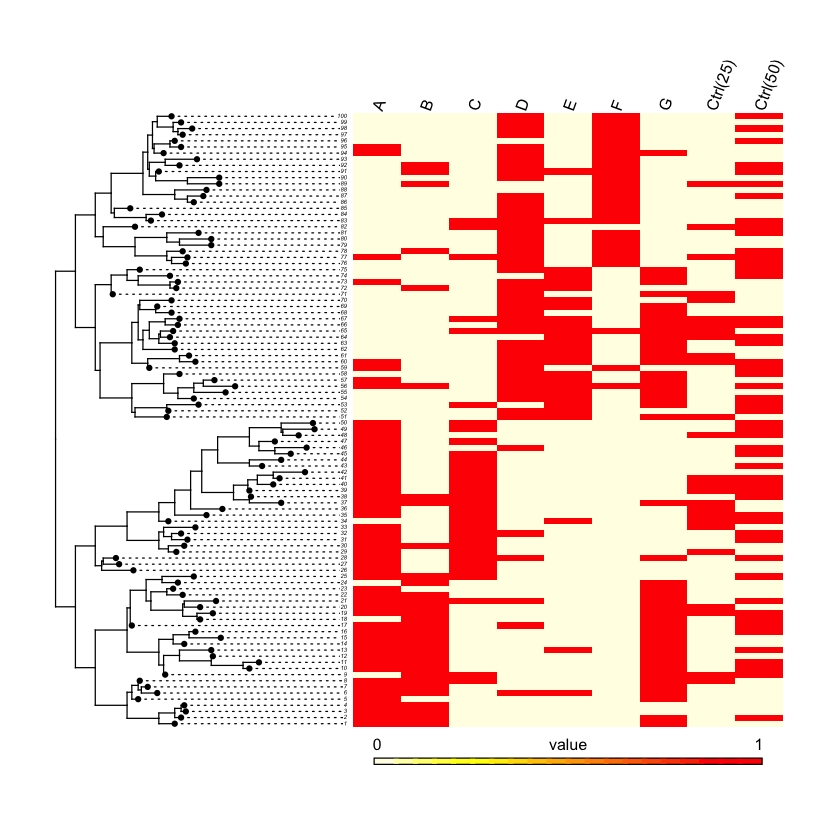

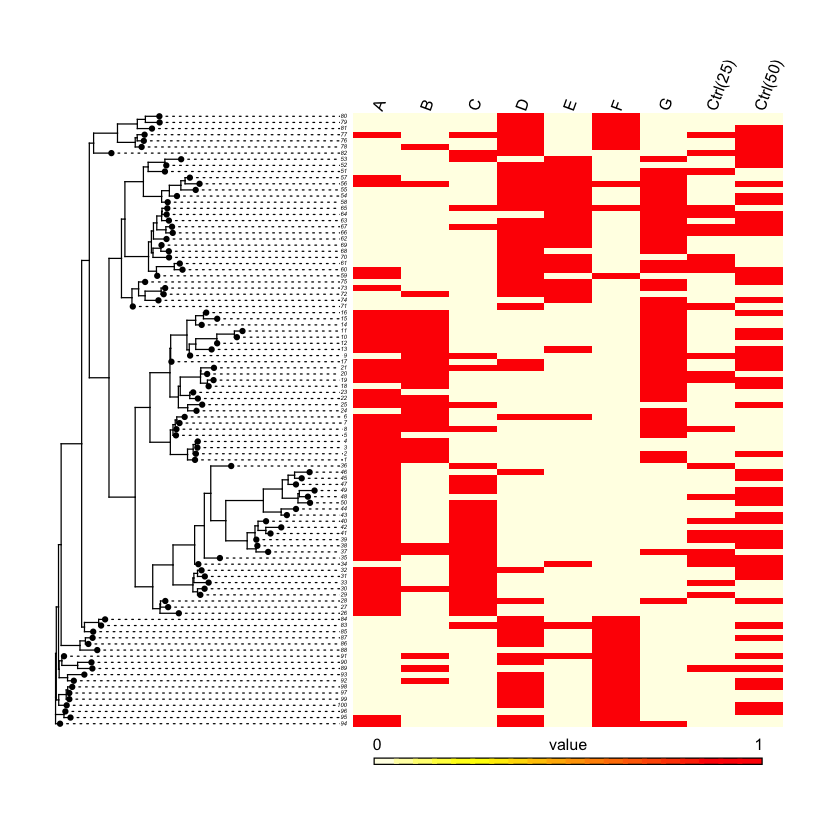

In [4]:
#error rate
beta <- 0.1

#create simulation traits
Nsub <- 25
N <- Nsub * 4
X <- matrix(0,N,9)
colnames(X) <- c("A","B","C","D","E","F","G","Ctrl(25)","Ctrl(50)")
X[1:(2*Nsub),1] <- 1
X[1:Nsub,2] <- 1
X[1:Nsub+Nsub,3] <- 1
X[1:(2*Nsub)+2*Nsub,4] <- 1
X[1:Nsub+2*Nsub,5] <- 1
X[1:Nsub+3*Nsub,6] <- 1
X[,7] <- X[,2] + X[,5]
X[,8] <- sample(X[,2])
X[,9] <- sample(X[,1])

#switching with probability beta
for(i in 1:dim(X)[2]){
  for(j in 1:dim(X)[1]){
    if(runif(1) < beta){
      X[j,i] <- 1 - X[j,i]
    }
  }
}

#true tree
tree <- read.tree("dataset_simulation/truetree.nwk")
rownames(X) <- as.character(tree$tip.label)
phylo.heatmap(tree, X, fsize=c(0.3,0.8,0.8))

#reconstructed tree with fasttree
fasttree <- read.tree("dataset_simulation/fasttree.nwk")
rownames(X) <- as.character(tree$tip.label)
phylo.heatmap(fasttree, X, fsize=c(0.3,0.8,0.8))

#normalization
for(i in 1:dim(X)[2]){
  X[,i] <- X[,i]/sqrt(sum(X[,i]**2))
}

In [5]:
#Parsimony Score
fasttree <- read.tree("dataset_simulation/fasttree.nwk")
fasttree$node.label <- NULL
rownames(X) <- 1:N

PSs <- rep(0,ncol(X))
names(PSs) <- colnames(X)
for(i in 1:dim(X)[2]){
  x <- X[,i]
  names(x) <- 1:N
  PSs[i] <- parsimony(fasttree, phyDat(x, type='USER', levels=c(min(x),max(x))))
}
print(PSs)

       A        B        C        D        E        F        G Ctrl(25) 
      12       11       13       13        9        5       11       20 
Ctrl(50) 
      36 


In [6]:
#phylosignal(Cmeans)
p4d <- phylo4d(fasttree, X)
tmp <- phyloSignal(p4d = p4d, method = "all")
Cmeans <- tmp$stat$Cmean
names(Cmeans) <- colnames(X)
print(Cmeans)

          A           B           C           D           E           F 
 0.54509936  0.43329452  0.46702299  0.45815562  0.41630884  0.66643055 
          G    Ctrl(25)    Ctrl(50) 
 0.48787078  0.16922760 -0.04533476 


In [7]:
#spectR_t(fragmenter)
fragmenters <- rep(0, ncol(X))
for(i in 1:ncol(X)){
  tmp <- spectR_t(fasttree, X[fasttree$tip.label,i], draw=F)
  fragmenters[i] <- tmp$fragmenter
}
names(fragmenters) <- colnames(X)
print(fragmenters)

       A        B        C        D        E        F        G Ctrl(25) 
9.125024 8.707773 8.758440 9.010659 9.099693 9.601360 8.946806 7.678684 
Ctrl(50) 
7.556960 


        A         B         C         D         E         F         G  Ctrl(25) 
0.4820932 0.5384523 0.5682062 0.4812748 0.4508434 0.3184967 0.4367647 0.8787347 
 Ctrl(50) 
0.9388640 


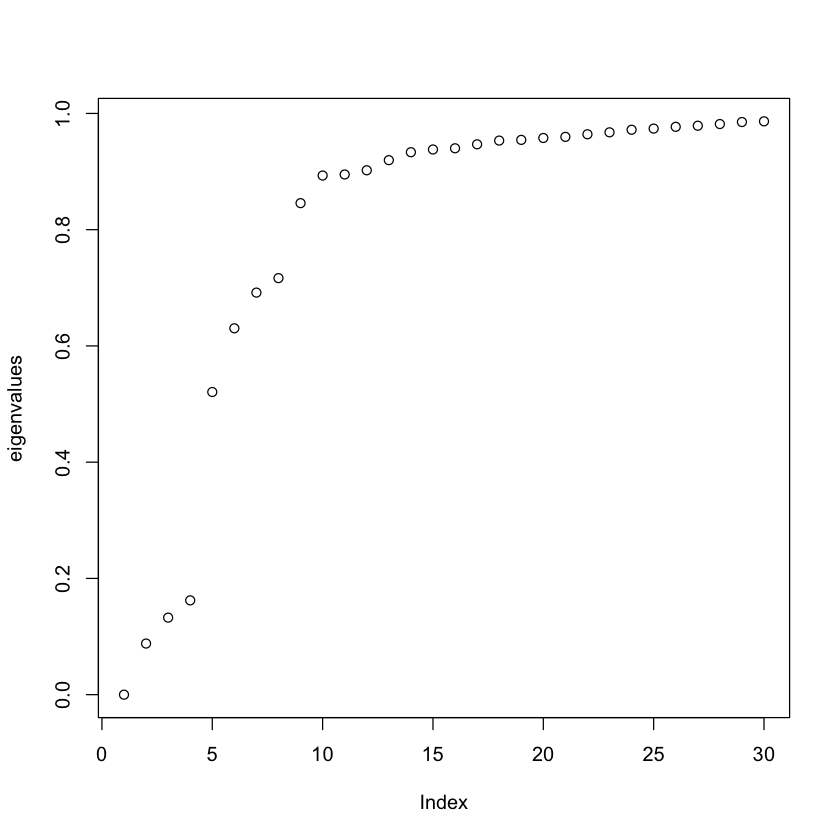

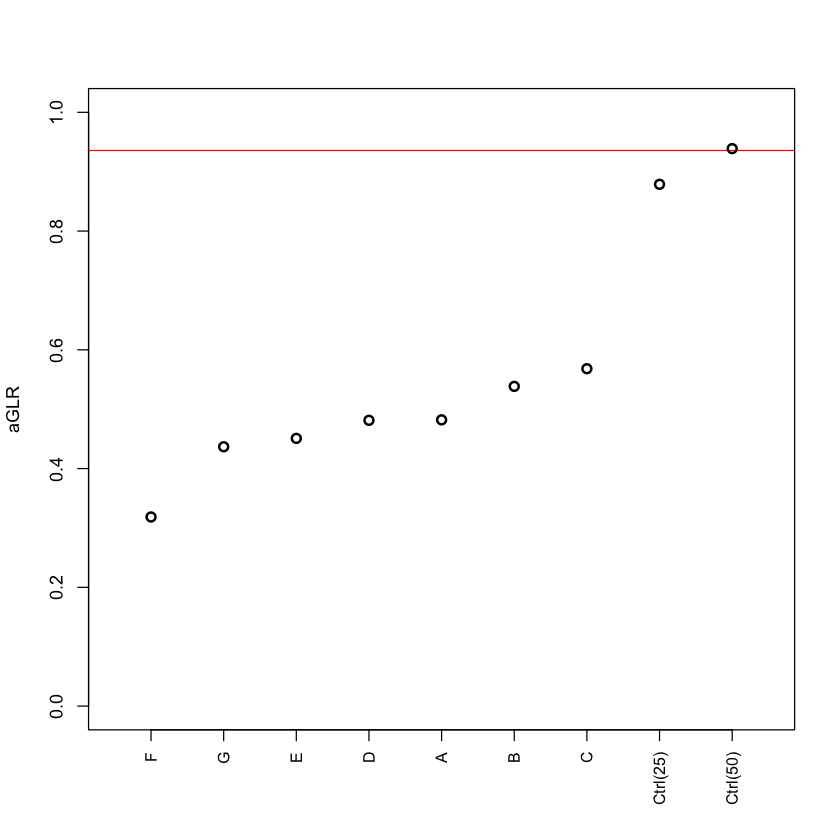

In [8]:
#aGLR
fin <- "dataset_simulation/KNN.txt"
A <- as.matrix(read.table(fin))
diag(A) <- 1
L <- sym_normalized_graph_laplacian(A)
tmp <- graph_fourier_transform(L,X,30)
U <- tmp$U
eigenvalues <- tmp$eigenvalues
hF <- tmp$hF
tF <- tmp$tF

aGLRs <- rep(0,ncol(X))
names(aGLRs) <- colnames(X)
for(i in 1:ncol(X)){
  aGLRs[i] <- graph_laplacian_regularizer(X[,i], U, eigenvalues)
}
print(aGLRs)

plot(eigenvalues)
plot_aGLR(X, U, 100)

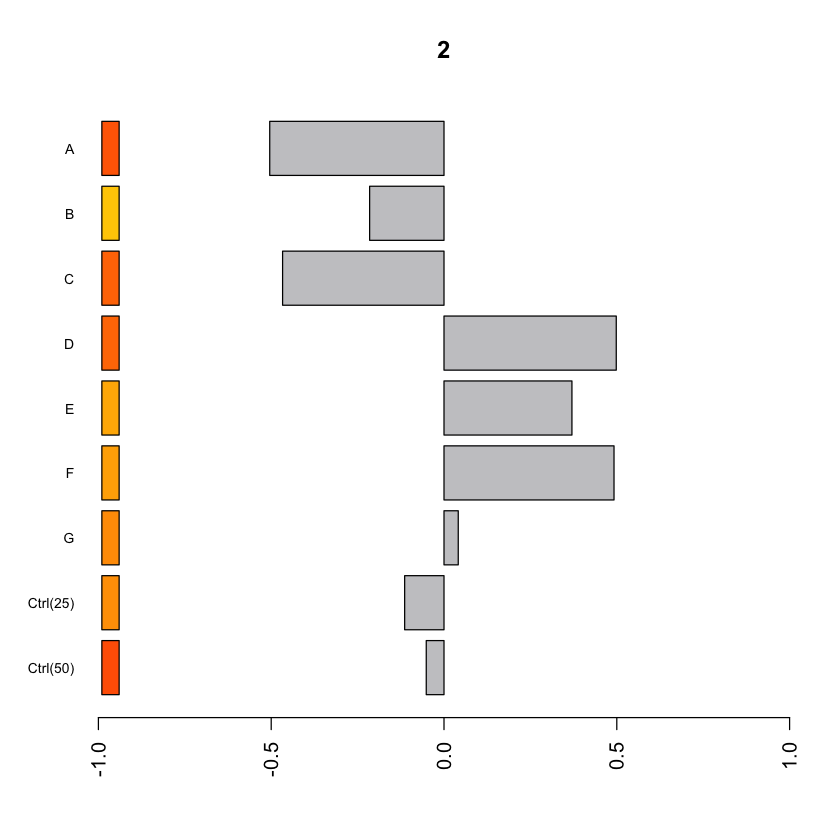

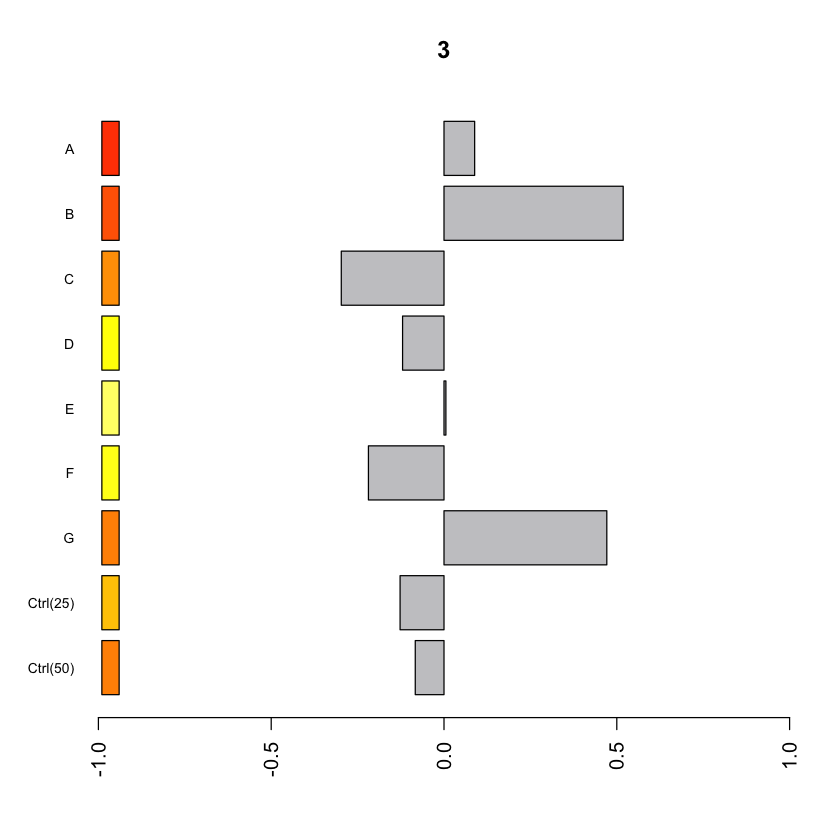

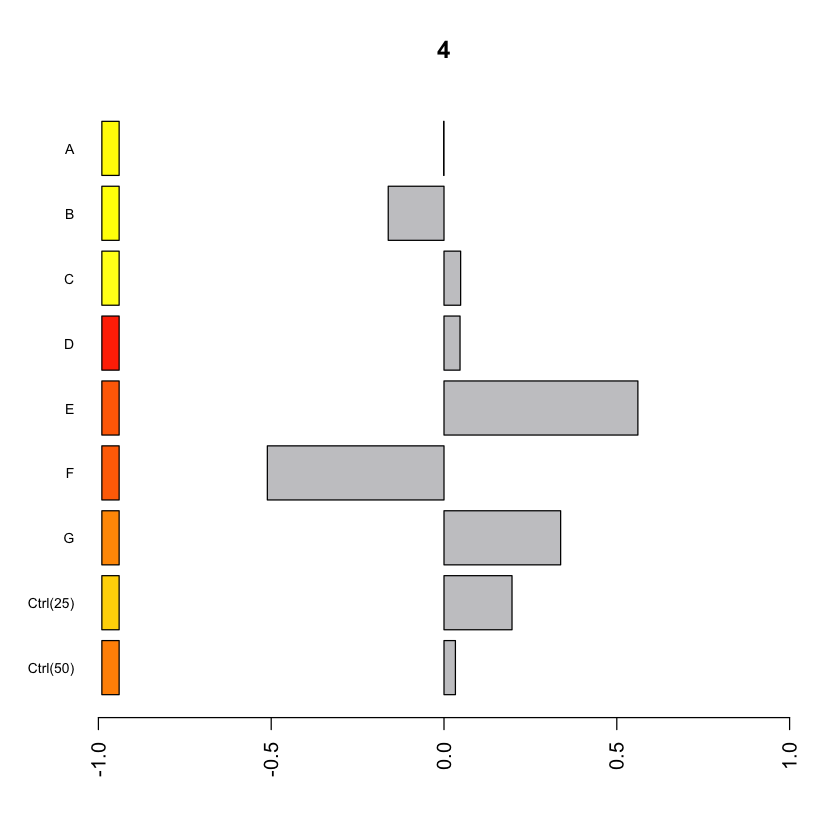

In [9]:
barplot_gfdomain(hF,tF,2)
barplot_gfdomain(hF,tF,3)
barplot_gfdomain(hF,tF,4)